<a href="https://colab.research.google.com/github/gyana-ranjan-dash/World_proverty_analysis/blob/main/World_poverty_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

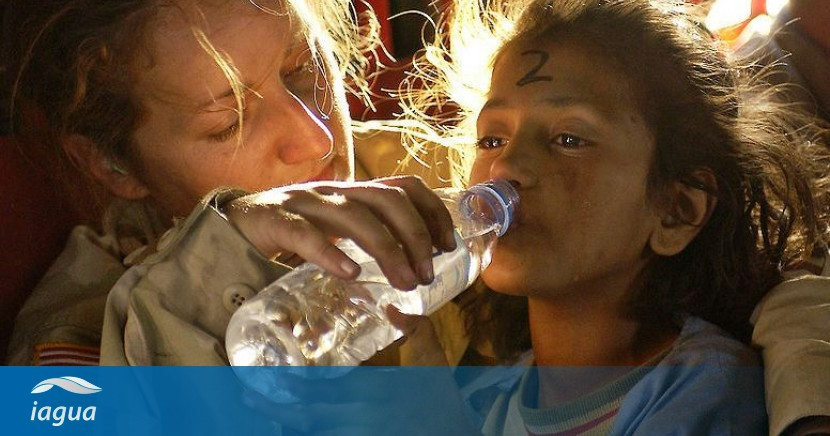

In [77]:
import warnings
warnings.filterwarnings('ignore')


#Important libraries

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import cut_tree

## **1. Reading and understanding Dataset**

In [78]:
# importing data from CSV file

country_df = pd.read_csv("https://raw.githubusercontent.com/gyana-ranjan-dash/World_proverty_analysis/main/Country-data.csv")

In [79]:
country_df.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,Afghanistan,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553
1,Albania,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090
2,Algeria,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460
3,Angola,119.0,62.3,2.85,42.9,5900,22.40,60.1,6.16,3530
4,Antigua and Barbuda,10.3,45.5,6.03,58.9,19100,1.44,76.8,2.13,12200


In [80]:
country_df.tail()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
162,Vanuatu,29.2,46.6,5.25,52.7,2950,2.62,63.0,3.50,2970
163,Venezuela,17.1,28.5,4.91,17.6,16500,45.90,75.4,2.47,13500
164,Vietnam,23.3,72.0,6.84,80.2,4490,12.10,73.1,1.95,1310
165,Yemen,56.3,30.0,5.18,34.4,4480,23.60,67.5,4.67,1310
166,Zambia,83.1,37.0,5.89,30.9,3280,14.00,52.0,5.40,1460


In [81]:
country_df.shape

(167, 10)

In [82]:
country_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167 entries, 0 to 166
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   country     167 non-null    object 
 1   child_mort  167 non-null    float64
 2   exports     167 non-null    float64
 3   health      167 non-null    float64
 4   imports     167 non-null    float64
 5   income      167 non-null    int64  
 6   inflation   167 non-null    float64
 7   life_expec  167 non-null    float64
 8   total_fer   167 non-null    float64
 9   gdpp        167 non-null    int64  
dtypes: float64(7), int64(2), object(1)
memory usage: 13.2+ KB


In [83]:
country_df.describe()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
count,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000
mean,38.270060,41.108976,6.815689,46.890215,17144.688623,7.781832,70.555689,2.947964,12964.155689
std,40.328931,27.412010,2.746837,24.209589,19278.067698,10.570704,8.893172,1.513848,18328.704809
min,2.600000,0.109000,1.810000,0.065900,609.000000,-4.210000,32.100000,1.150000,231.000000
25%,8.250000,23.800000,4.920000,30.200000,3355.000000,1.810000,65.300000,1.795000,1330.000000
50%,19.300000,35.000000,6.320000,43.300000,9960.000000,5.390000,73.100000,2.410000,4660.000000
75%,62.100000,51.350000,8.600000,58.750000,22800.000000,10.750000,76.800000,3.880000,14050.000000
max,208.000000,200.000000,17.900000,174.000000,125000.000000,104.000000,82.800000,7.490000,105000.000000


In [84]:
country_df.isnull().mean()*100

country       0.0
child_mort    0.0
exports       0.0
health        0.0
imports       0.0
income        0.0
inflation     0.0
life_expec    0.0
total_fer     0.0
gdpp          0.0
dtype: float64



--- We can see the dataset ``country_df`` do not contain any null values



--- All the columns have correct data type






## **Data  preparation and Cleaning**

In [85]:
country_df['exports'] = country_df['exports']*country_df['gdpp']/100
country_df['imports'] = country_df['imports']*country_df['gdpp']/100
country_df['health'] = country_df['health']*country_df['gdpp']/100

In [86]:
country_df.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,Afghanistan,90.2,55.30,41.9174,248.297,1610,9.44,56.2,5.82,553
1,Albania,16.6,1145.20,267.8950,1987.740,9930,4.49,76.3,1.65,4090
2,Algeria,27.3,1712.64,185.9820,1400.440,12900,16.10,76.5,2.89,4460
3,Angola,119.0,2199.19,100.6050,1514.370,5900,22.40,60.1,6.16,3530
4,Antigua and Barbuda,10.3,5551.00,735.6600,7185.800,19100,1.44,76.8,2.13,12200


## **EDA**

(9.5, -0.5)

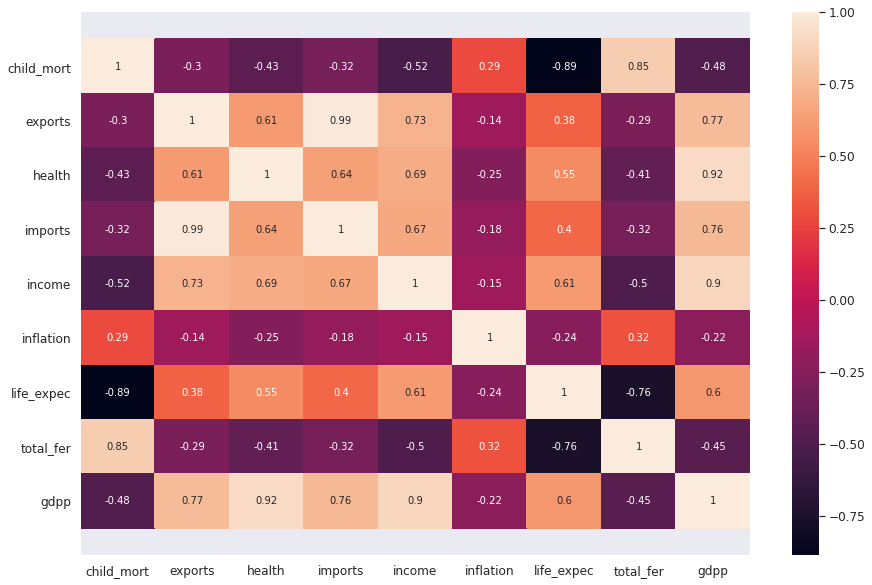

In [87]:
# Heatmap to understand the attributes dependency

plt.figure(figsize = (15,10))        
ax = sns.heatmap(country_df.corr(),annot = True)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

**inference**


*   ``child_mortality`` and ``life_expentency`` are highly correlated 
*   ``child_mortality`` and ``total_fertility`` are highly correlated 
*   ``imports`` and ``exports`` are highly correlated
*   ``life_expentency`` and ``total_fertility`` are highly correlated



In [88]:
# dataframe with pnly required columns
df = country_df[["country","child_mort","income","gdpp"]]
df.head()

,country,child_mort,income,gdpp
0,Afghanistan,90.2,1610,553
1,Albania,16.6,9930,4090
2,Algeria,27.3,12900,4460
3,Angola,119.0,5900,3530
4,Antigua and Barbuda,10.3,19100,12200


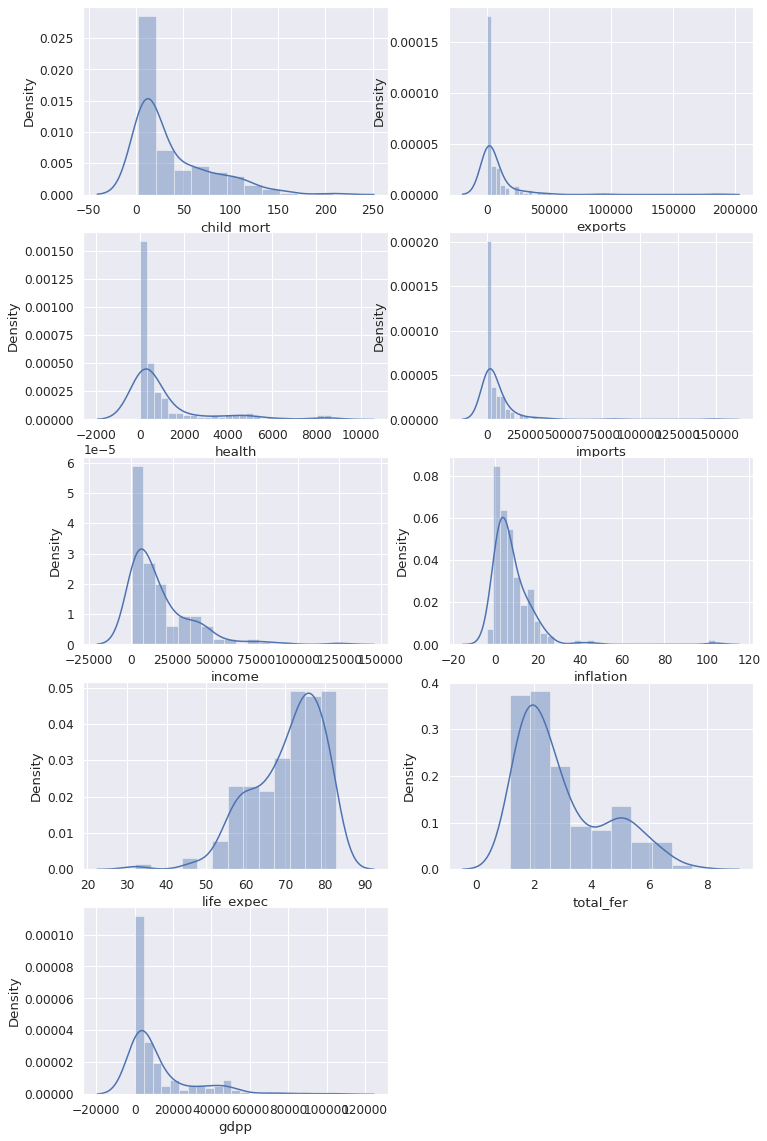

In [89]:
plt.figure(figsize=(12,20))
sns.set(font_scale = 1.1)
cols = country_df.columns[1:]
for i in enumerate(cols):
    plt.subplot(5,2,i[0]+1)
    sns.distplot(country_df[i[1]])
plt.show()

#### Inference :-
- all the variables are not noramlly distrubuted
- ``child_mort`` ``exports`` ``health`` ``imports`` ``income`` ``inflation`` ``total_fer`` and ``gdpp`` are positively skewed
- ``life_expec`` negatively skewed

<Figure size 720x360 with 0 Axes>

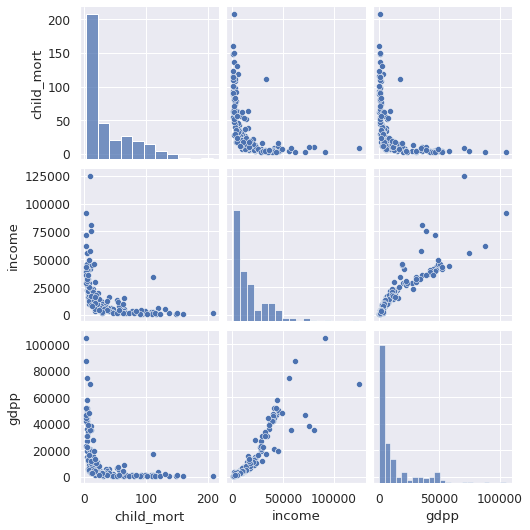

In [90]:
plt.figure(figsize=(10,5))
sns.pairplot(df)
plt.show()

### **Outlier Treatment**

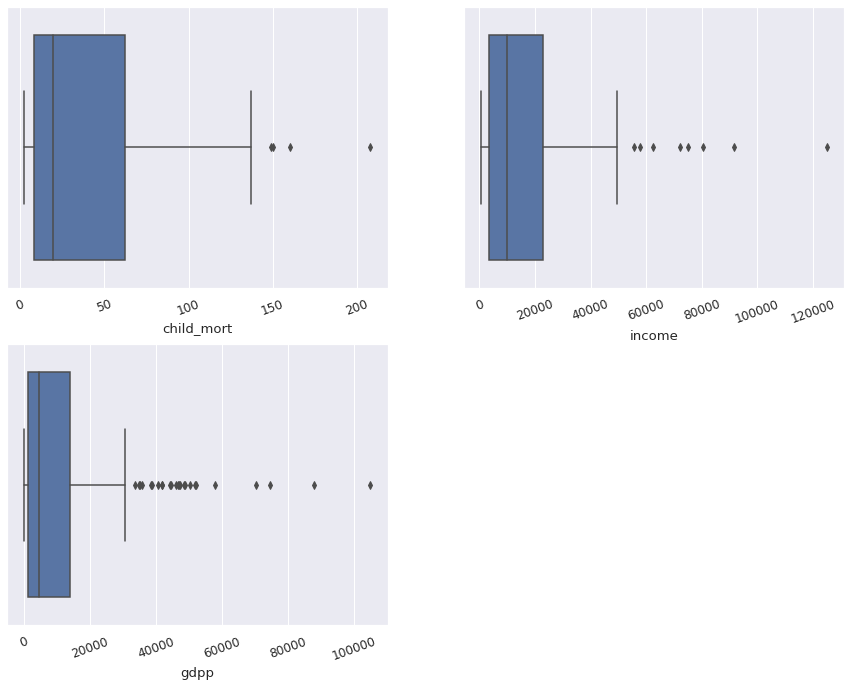

In [91]:
# checking for outliers
plt.figure(figsize=(15,30))
features = ['child_mort','income','gdpp']
for i in enumerate(features): 
    ax = plt.subplot(5, 2, i[0]+1)
    sns.boxplot(df[i[1]])
    plt.xticks(rotation = 20)

*There are outliers in every column*


1.   We cannot remove all the outliers from the columns as they are crucial for our analysis
2.   we can cap high value outlier with in ``income`` ``gdpp``  as we dont require them in our final result



In [92]:
q1 = df['gdpp'].quantile(0.95)
q2 = df['income'].quantile(0.95)
df['gdpp'][df['gdpp']>=q1] = q1
df['income'][df['income']>=q2] = q2

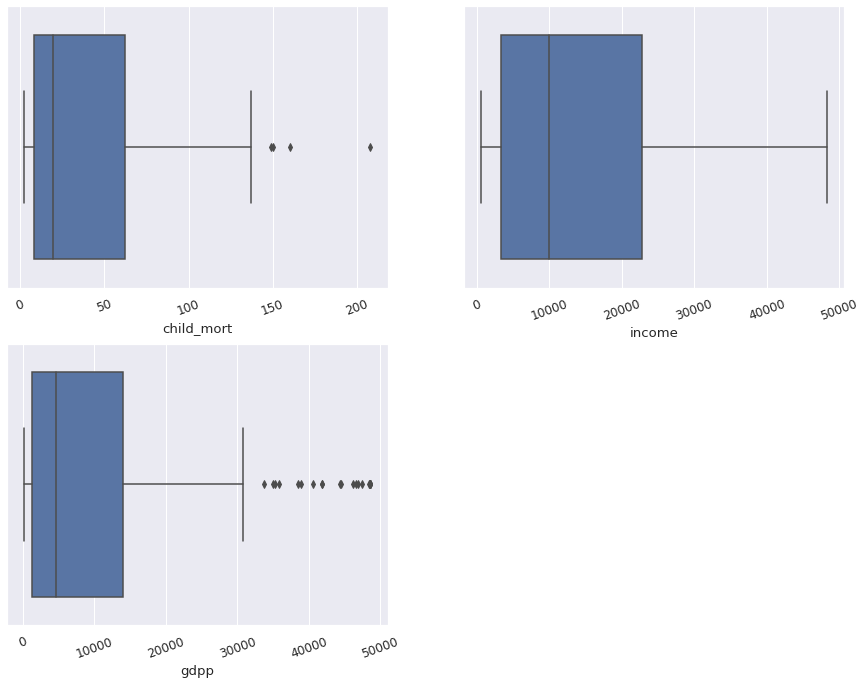

In [93]:
# checking for outliers
plt.figure(figsize=(15,30))
features = ['child_mort','income','gdpp']
for i in enumerate(features): 
    ax = plt.subplot(5, 2, i[0]+1)
    sns.boxplot(df[i[1]])
    plt.xticks(rotation = 20)

### **Scaling data**

In [94]:
# Dropping Country field as final dataframe will only contain data columns

df_country_drop = country_df.copy()
country = df_country_drop.pop('country')

In [95]:
df_country_drop.head()


,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,90.2,55.30,41.9174,248.297,1610,9.44,56.2,5.82,553
1,16.6,1145.20,267.8950,1987.740,9930,4.49,76.3,1.65,4090
2,27.3,1712.64,185.9820,1400.440,12900,16.10,76.5,2.89,4460
3,119.0,2199.19,100.6050,1514.370,5900,22.40,60.1,6.16,3530
4,10.3,5551.00,735.6600,7185.800,19100,1.44,76.8,2.13,12200


In [96]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
df_country_scaled = scaler.fit_transform(df_country_drop)

In [97]:
df_country_scaled

array([[ 1.29153238, -0.4110113 , -0.56503989, ..., -1.61909203,
         1.90288227, -0.67917961],
       [-0.5389489 , -0.35019096, -0.43921769, ...,  0.64786643,
        -0.85997281, -0.48562324],
       [-0.27283273, -0.31852577, -0.48482608, ...,  0.67042323,
        -0.0384044 , -0.46537561],
       ...,
       [-0.37231541, -0.36146329, -0.53848844, ...,  0.28695762,
        -0.66120626, -0.63775406],
       [ 0.44841668, -0.39216643, -0.55059641, ..., -0.34463279,
         1.14094382, -0.63775406],
       [ 1.11495062, -0.38395214, -0.54049845, ..., -2.09278484,
         1.6246091 , -0.62954556]])

## **Hopkins Statistics Test**

The ``Hopkins statistic`` is a ``way of measuring the cluster tendency`` of a data set.It acts as a statistical hypothesis test where the null hypothesis is that the data is generated by a Poisson point process and are thus uniformly randomly distributed. A value close to 1 tends to indicate the data is highly clustered, random data will tend to result in values around 0.5, and uniformly distributed data will tend to result in values close to 0.

In [98]:
from sklearn.neighbors import NearestNeighbors
from random import sample
from numpy.random import uniform
import numpy as np
from math import isnan
 
def hopkins(X):
    d = X.shape[1]
    #d = len(vars) # columns
    n = len(X) # rows
    m = int(0.1 * n) 
    nbrs = NearestNeighbors(n_neighbors=1).fit(X.values)
 
    rand_X = sample(range(0, n, 1), m)
 
    ujd = []
    wjd = []
    for j in range(0, m):
        u_dist, _ = nbrs.kneighbors(uniform(np.amin(X,axis=0),np.amax(X,axis=0),d).reshape(1, -1), 2, return_distance=True)
        ujd.append(u_dist[0][1])
        w_dist, _ = nbrs.kneighbors(X.iloc[rand_X[j]].values.reshape(1, -1), 2, return_distance=True)
        wjd.append(w_dist[0][1])
 
    H = sum(ujd) / (sum(ujd) + sum(wjd))
    if isnan(H):
        print(ujd, wjd)
        H = 0
 
    return H

In [99]:
hopkins(df_country_drop)


0.9678214079646932



*   As after several random runs the value of hopkins score is above ``0.85`` we can conclude that the data is good for clustering




## **Model Building**

**K- means Clustering**

K-means clustering is one of the simplest and popular unsupervised machine learning algorithms.

The algorithm works as follows:

First we initialize k points, called means, randomly. We categorize each item to its closest mean and we update the mean’s coordinates, which are the averages of the items categorized in that mean so far. We repeat the process for a given number of iterations and at the end, we have our clusters.

**Finding the Optimal Number of Clusters**

**Elbow Curve to get the right number of Clusters**

A fundamental step for any unsupervised algorithm is to determine the optimal number of clusters into which the data may be clustered. The Elbow Method is one of the most popular methods to determine this optimal value of k.

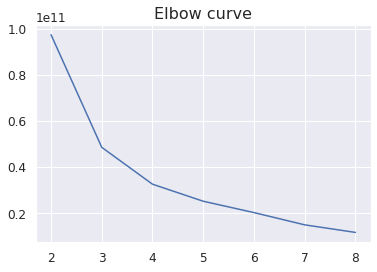

In [100]:
ssd = []
labels= [2, 3, 4, 5, 6, 7, 8]
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]
for num_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50)
    kmeans.fit(df_country_drop)
    
    ssd.append(kmeans.inertia_)
plt.plot(ssd)
plt.title('Elbow curve',fontsize = 16)
plt.xticks([0,1,2,3,4,5,6],labels)
plt.show()



*   Looking at the above elbow curve we can choose 6 or 7 clusters






#### **Silhouette Analysis**

In [101]:
# silhouette analysis
range_n_clusters = [2, 3, 4, 5, 6, 7, 8,9,10]

for num_clusters in range_n_clusters:
    
    # intialise kmeans
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50)
    kmeans.fit(df_country_drop)
    
    cluster_labels = kmeans.labels_
    
    # silhouette score
    silhouette_avg = silhouette_score(df_country_drop, cluster_labels)
    print("For n_clusters={0}, the silhouette score is {1}".format(num_clusters, silhouette_avg))
    
    

For n_clusters=2, the silhouette score is 0.712586926709893
For n_clusters=3, the silhouette score is 0.7010999403856036
For n_clusters=4, the silhouette score is 0.6876753336765676
For n_clusters=5, the silhouette score is 0.5691311238383122
For n_clusters=6, the silhouette score is 0.5314887374931582
For n_clusters=7, the silhouette score is 0.5391498956530251
For n_clusters=8, the silhouette score is 0.5373642116459425
For n_clusters=9, the silhouette score is 0.5439779925632694
For n_clusters=10, the silhouette score is 0.5461150033938122


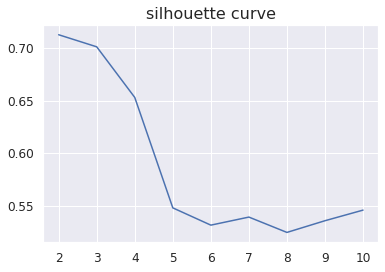

In [102]:
from sklearn.metrics import silhouette_score
ss = []
for k in range(2,11):
    kmeans = KMeans(n_clusters = k).fit(df_country_drop)
    ss.append([k, silhouette_score(df_country_drop, kmeans.labels_)])

plt.plot(pd.DataFrame(ss)[0], pd.DataFrame(ss)[1])
plt.title('silhouette curve',fontsize = 16)
plt.show()

In [105]:
#K-means with k=5 clusters

cluster5 = KMeans(n_clusters=5, max_iter=50, random_state= 100)
cluster5.fit(df_country_drop)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=50,
       n_clusters=5, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=100, tol=0.0001, verbose=0)

In [106]:
# Cluster labels

cluster5.labels_

array([4, 4, 4, 4, 0, 0, 4, 2, 2, 0, 0, 2, 4, 0, 0, 2, 4, 4, 4, 4, 4, 4,
       0, 2, 0, 4, 4, 4, 4, 2, 4, 4, 4, 0, 4, 4, 4, 4, 4, 0, 4, 0, 2, 0,
       2, 4, 4, 4, 4, 0, 4, 0, 4, 2, 2, 0, 4, 4, 2, 4, 0, 4, 4, 4, 4, 4,
       4, 0, 2, 4, 4, 0, 4, 1, 2, 2, 4, 2, 4, 0, 4, 4, 2, 4, 4, 0, 0, 4,
       4, 0, 0, 3, 4, 4, 4, 0, 4, 4, 2, 4, 0, 4, 4, 4, 0, 4, 4, 4, 4, 4,
       2, 2, 4, 4, 1, 2, 4, 0, 4, 4, 4, 0, 0, 1, 0, 0, 4, 4, 2, 4, 4, 0,
       4, 1, 0, 0, 4, 4, 0, 2, 4, 4, 4, 0, 2, 1, 4, 4, 4, 4, 4, 4, 4, 0,
       4, 4, 4, 2, 2, 2, 0, 4, 4, 0, 4, 4, 4], dtype=int32)

In [107]:
df_country_drop['Cluster_Id5'] = cluster5.labels_
df_country_drop.head()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,Cluster_Id5
0,90.2,55.30,41.9174,248.297,1610,9.44,56.2,5.82,553,4
1,16.6,1145.20,267.8950,1987.740,9930,4.49,76.3,1.65,4090,4
2,27.3,1712.64,185.9820,1400.440,12900,16.10,76.5,2.89,4460,4
3,119.0,2199.19,100.6050,1514.370,5900,22.40,60.1,6.16,3530,4
4,10.3,5551.00,735.6600,7185.800,19100,1.44,76.8,2.13,12200,0


In [108]:
# Number of countries in each cluster

df_country_drop['Cluster_Id5'].value_counts()

4    96
0    39
2    26
1     5
3     1
Name: Cluster_Id5, dtype: int64

In [111]:
df_country_drop['k_means_cluster'] = kmean.labels_
df_country_drop.head()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,Cluster_Id5,k_means_cluster
0,90.2,55.30,41.9174,248.297,1610,9.44,56.2,5.82,553,4,0
1,16.6,1145.20,267.8950,1987.740,9930,4.49,76.3,1.65,4090,4,0
2,27.3,1712.64,185.9820,1400.440,12900,16.10,76.5,2.89,4460,4,0
3,119.0,2199.19,100.6050,1514.370,5900,22.40,60.1,6.16,3530,4,0
4,10.3,5551.00,735.6600,7185.800,19100,1.44,76.8,2.13,12200,0,4


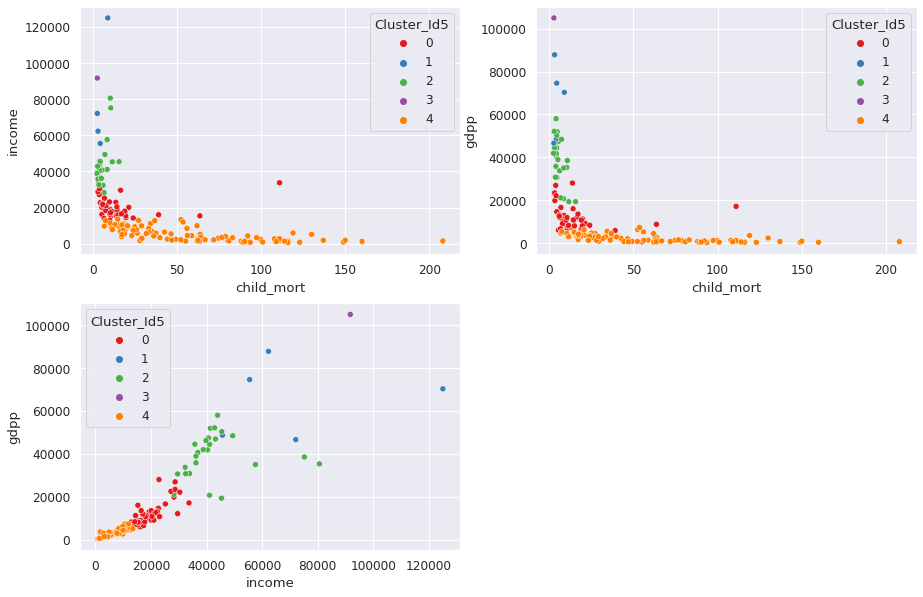

In [112]:
plt.figure(figsize=(15,10))
plt.subplot(2,2,1)
sns.scatterplot(x = 'child_mort', y = 'income', hue = 'Cluster_Id5', data = df_country_drop, palette = 'Set1')
plt.subplot(2,2,2)
sns.scatterplot(x = 'child_mort', y = 'gdpp', hue = 'Cluster_Id5', data = df_country_drop, palette = 'Set1')
plt.subplot(2,2,3)
sns.scatterplot(x = 'income', y = 'gdpp', hue = 'Cluster_Id5', data = df_country_drop, palette = 'Set1')

**Inferences**

*   ``child mortality`` is higher for the country with lower ``income`` and ``gdpp``
*   higher ``gdpp`` linked to higher ``income``



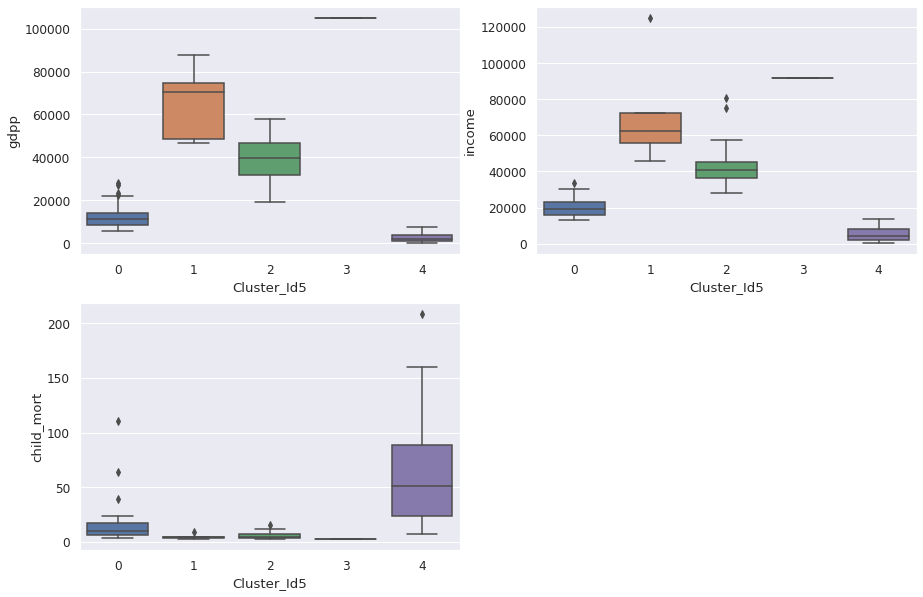

In [116]:
plt.figure(figsize=(15,10))
plt.subplot(2,2,1)
sns.boxplot(x='Cluster_Id5', y='gdpp', data=df_country_drop)
plt.subplot(2,2,2)
sns.boxplot(x='Cluster_Id5', y='income', data=df_country_drop)
plt.subplot(2,2,3)
sns.boxplot(x='Cluster_Id5', y='child_mort', data=df_country_drop)
plt.show()

**INFERENCES**


*   Cluster 4 contains most countries where child mortality is high

